selected_region ['Seoul', 'Tokyo', 'Hong Kong', 'Osaka', 'Singapore', 'Sydney', 'Frankfurt', 'London', 'N. California', 'Ireland', 'Mumbai', 'N. Virginia', 'Ohio', 'Oregon', 'Stockholm']
             mean
count  210.000000
mean   140.846762
std     70.655170
min      9.810000
25%     86.330000
50%    140.995000
75%    200.322500
max    269.300000


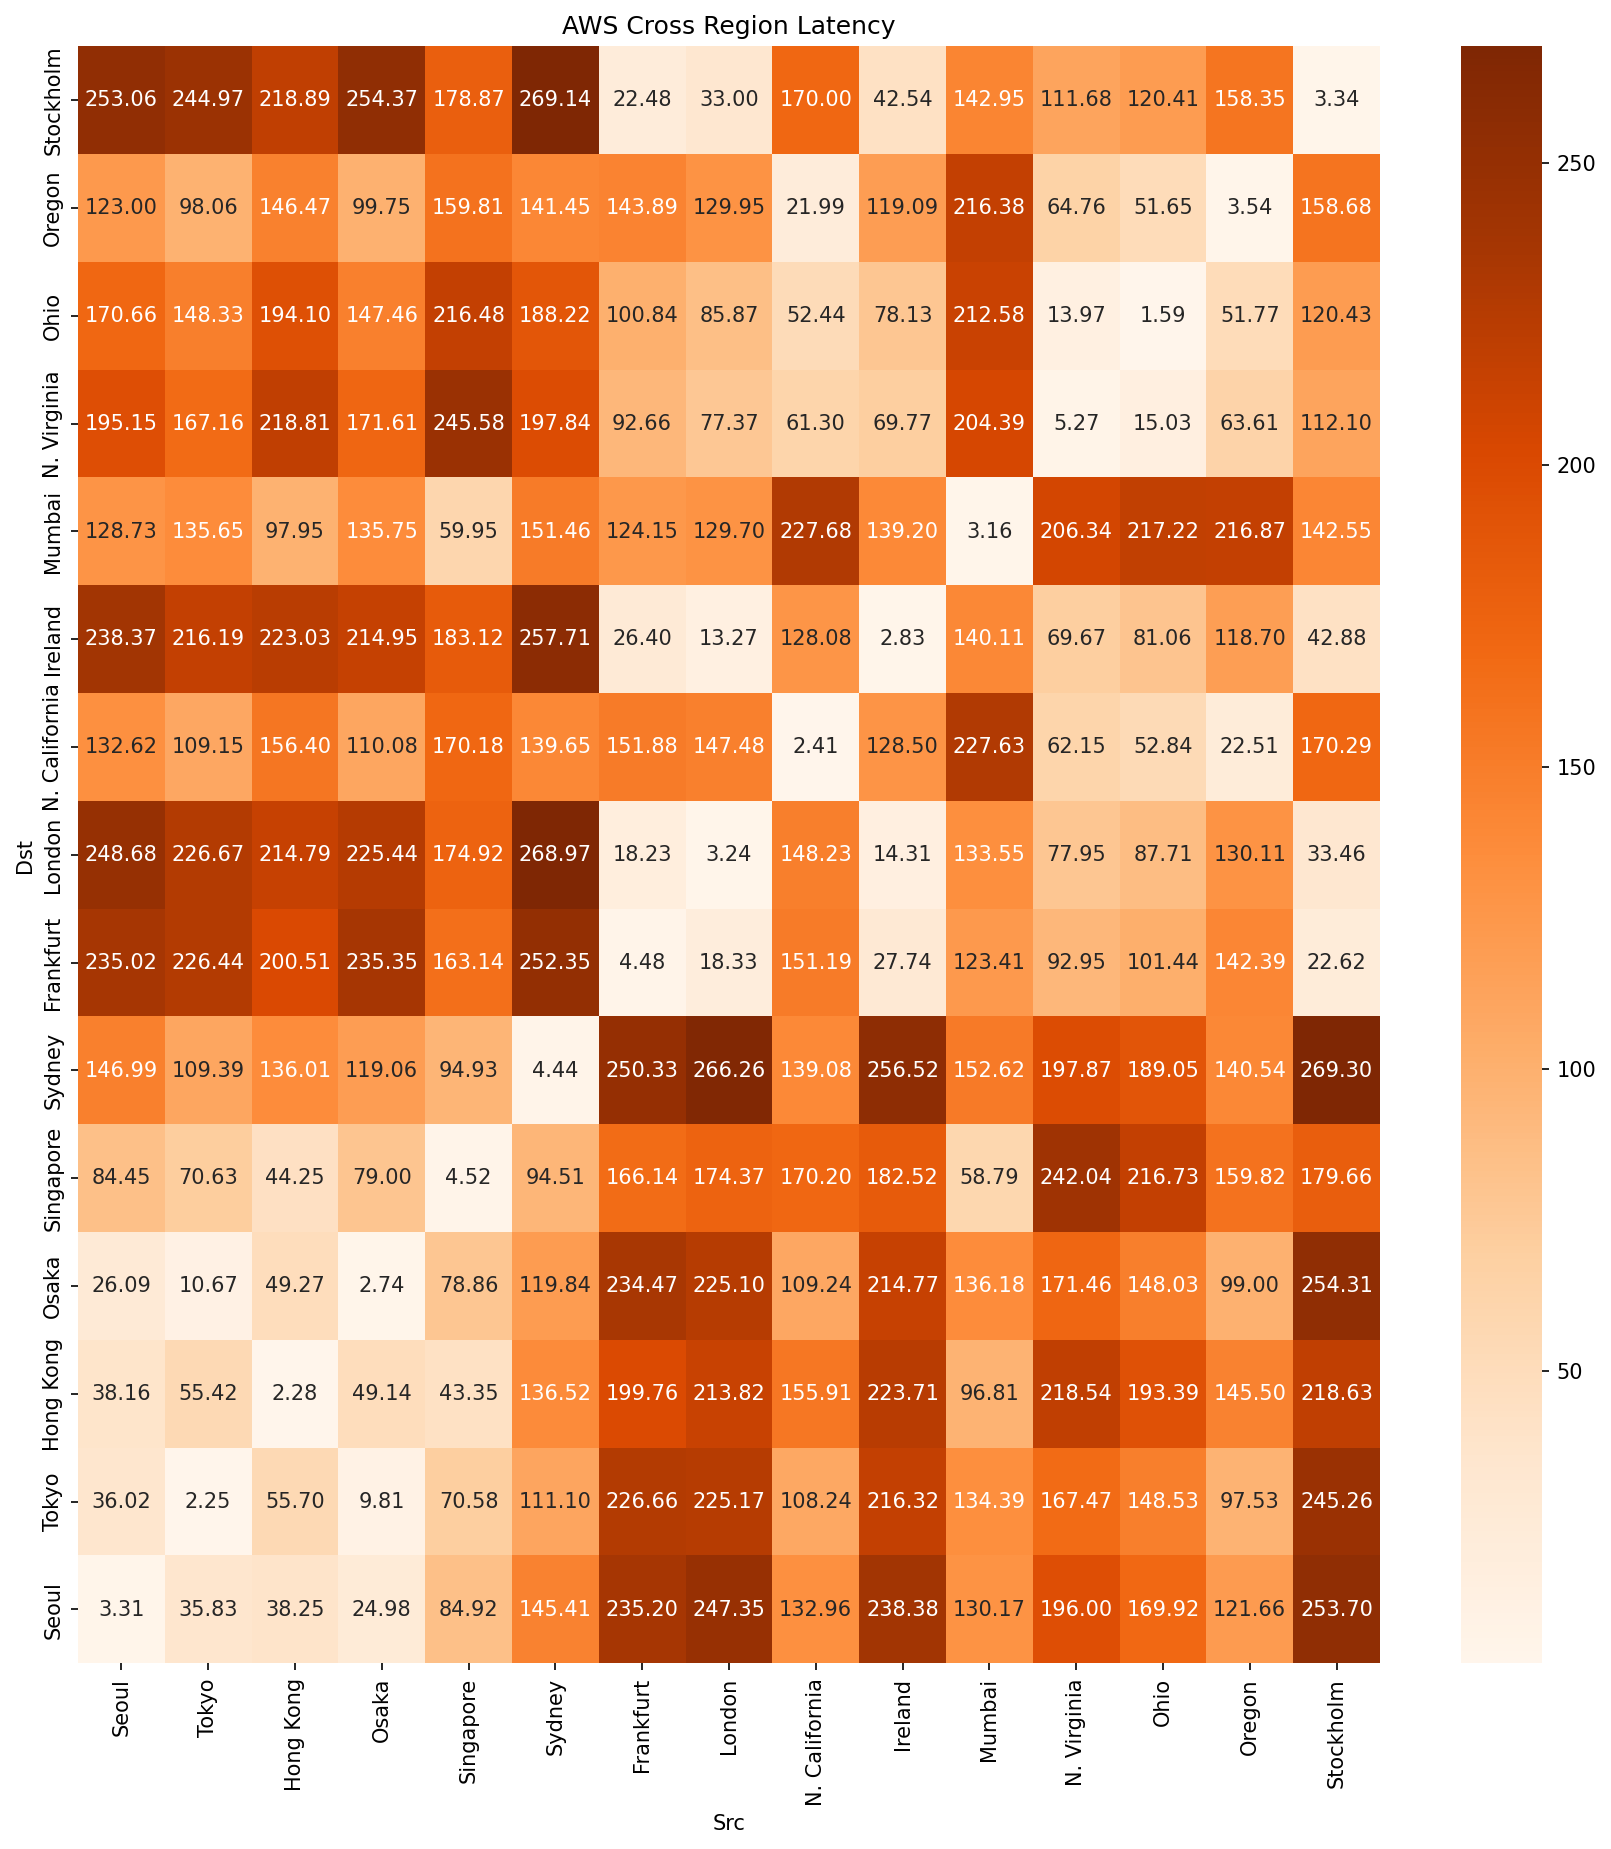

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re  
import numpy as np

plt.rcParams['figure.dpi'] = 150

def calculate_latency_mean_std_from(region1, region2, latency_stats):
    """
    Simulate latency between two regions using normal distribution.
    
    Parameters:
        region1 (str): First region name
        region2 (str): Second region name
        latency_stats (dict): Dictionary of latency DataFrames by percentiles and average
    
    Returns:
        float: Simulated latency value
    """
    # 평균 및 표준 편차 추정
    mean = latency_stats['50th'].loc[region1, region2]
    std = (latency_stats['75th'].loc[region1, region2] - latency_stats['25th'].loc[region1, region2]) / 2
    
    # 정규 분포에서 지연 시간 샘플링
    # simulated_latency = np.random.normal(mean, std)
    return {
        "mean": mean,
        "std": std,
    }


def extract_region_name(full_name):
    """
    Extract the name within parentheses from the full region name.
    
    Parameters:
        full_name (str): Full name of the region
    
    Returns:
        str: Extracted short name of the region
    """
    match = re.search(r'\((.*?)\)', full_name)
    if match:
        return match.group(1)  # 괄호 안의 문자열 반환
    return full_name  # 매치가 없으면 원본 이름 반환

# 파일 경로 설정
file_path = 'data/AWS Cross Region Latency 240419.xlsx'

selected_regions = []
with open('selected_region.txt', 'r') as file:
    for line in file:
        selected_regions.append(line.strip())  # line.strip()을 사용하여 줄바꿈 문자를 제거
print("selected_region", selected_regions)


# 시트 이름 및 필요한 데이터를 로드
percentiles = ['10th', '25th', '50th', '75th', '90th', '99th', 'Avg']

#
# 데이터 프레임을 저장할 딕셔너리
latency_data = {}

# 각 백분위수별로 데이터 로드
for percentile in percentiles:
    df = pd.read_excel(file_path, sheet_name=percentile, index_col=0)
    # 필터링된 데이터만 추출
    filtered_index = [idx for idx in df.index if any(region in idx for region in selected_regions)]
    filtered_columns = [col for col in df.columns if any(region in col for region in selected_regions)]
    # 데이터 프레임 생성
    filtered_df = df.loc[filtered_index, filtered_columns]
    # 인덱스 및 컬럼 이름 정리
    filtered_df.index = [extract_region_name(idx) for idx in filtered_df.index]
    filtered_df.columns = [extract_region_name(col) for col in filtered_df.columns]
    # 저장
    latency_data[percentile] = filtered_df
    # print(filtered_df)


simulated_parameters = []

for src in selected_regions:
    for dst in selected_regions:
        # if src == dst:
        #     continue
        param = calculate_latency_mean_std_from(src, dst, latency_data)
        simulated_parameters.append({
            "src": src,
            "dst": dst,
            "mean": param["mean"],
            "std": param["std"],
        })

csv_file_path="data/AWSCrossRegionLatencyMatrixParams_240419.csv"
df_simulated = pd.DataFrame(simulated_parameters)
df_simulated['std'] = df_simulated['std'].map(lambda x: f"{x:.4f}")

df_simulated.to_csv(csv_file_path, index=False)


# Display latency heatmap among selected AWS regions
pivot_df = df_simulated.pivot(index='dst', columns='src', values='mean')
pivot_df = pivot_df.reindex(index=selected_regions[::-1], columns=selected_regions)

# possible_cmaps=['Blues', 'Greens', 'Greys', 'Oranges', 'Purples', 'Reds']
plt.figure(figsize=(14, 14))  # 그래프 크기 조정
ax = sns.heatmap(pivot_df, annot=True, cmap='Oranges', fmt=".2f")  # annot=True로 셀 내부에 숫자 표시, fmt는 숫자 포맷 설정
plt.title('AWS Cross Region Latency')  # 제목 설정
plt.xlabel('Src')  # x축 라벨
plt.ylabel('Dst')  # y축 라벨
plt.savefig("fig.jpg", bbox_inches='tight')
# plt.show()
# plt.close()
# Display statistics of selected AWS regions, except for the case where src = dst
filtered_df = df_simulated[df_simulated['src'] != df_simulated['dst']]
print(filtered_df.describe())